##### Часть 1. Загрузка, изучение и подготовка данных:
* [1. Подключение необходимых библиотек и импортирование функций.](#10.1-bullet)
* [2. Загрузка и ресемплирование данных.](#10.2-bullet)
* [3. Анализ данных.](#10.3-bullet)

##### Часть 2. Обучение моделей:
* [4. Обучение модели "Линейная регрессия".](#10.4-bullet)
* [5. Обучение модели "Случайный лес".](#10.5-bullet)
* [6. Обучение модели "Градиентный бустинг".](#10.6-bullet)

##### Часть 3. Анализ моделей:
* [7. Тестирование модели "Линейная регрессия".](#10.7-bullet)
* [8. Тестирование "Случайный лес".](#10.8-bullet)
* [9. Тестирование "Градиентный бучтинг".](#10.9-bullet)
* [10. Вывод.](#10.10-bullet)


## Часть 1. Загрузка, изучение и подготовка данных. 

<a id='10.1-bullet'></a> 
### 1. Подключение необходимых библиотек и импортирование функций. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from itertools import product
from lightgbm import LGBMRegressor

pd.options.mode.chained_assignment = None

RANDOM_STATE = 123456
LOW_SEARCH_DEPTH = True

<a id='10.2-bullet'></a> 
### 2. Загрузка и ресемплирование данных. 

Загрузим данные, одновременно изменив тип данных datetime с object на datetime64 и проиндексировав из по этому столбцу.

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('../datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Выведем общую информацию о данных в таблице *data*

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Чтобы данные точно оказались в хронологическом порядке, осортируем их по индексу.

In [5]:
data.sort_index(inplace=True)

В исходных данных представлено количество вызовов каждые 10 минут. Ресемплируем их по одному часу.

In [6]:
data = data.resample('1H').sum()

Посмотрим общую информацию.

In [7]:
data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<a id='10.3-bullet'></a> 
### 3. Анализ данных. 

Посмотрим график вызовов такси по часам.

[Text(0, 0.5, 'Количество вызовов'), Text(0.5, 0, 'Время')]

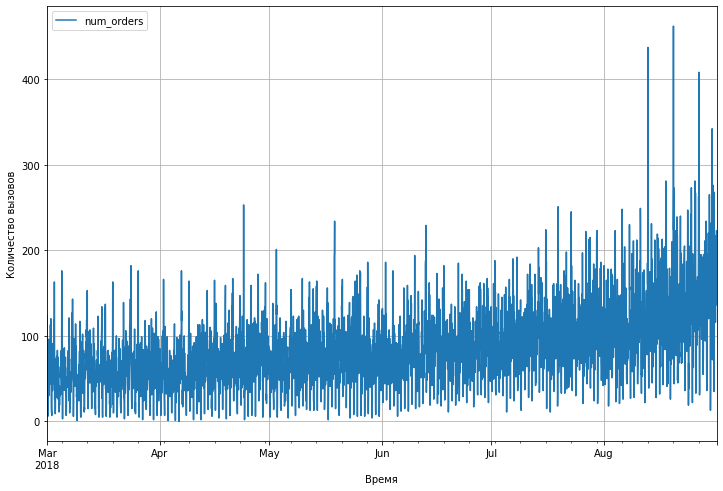

In [8]:
data.plot(grid=True, figsize=(12, 8))
plt.gca().set(xlabel='Время', ylabel='Количество вызовов')

Выделим тренд и сезонность в данных.

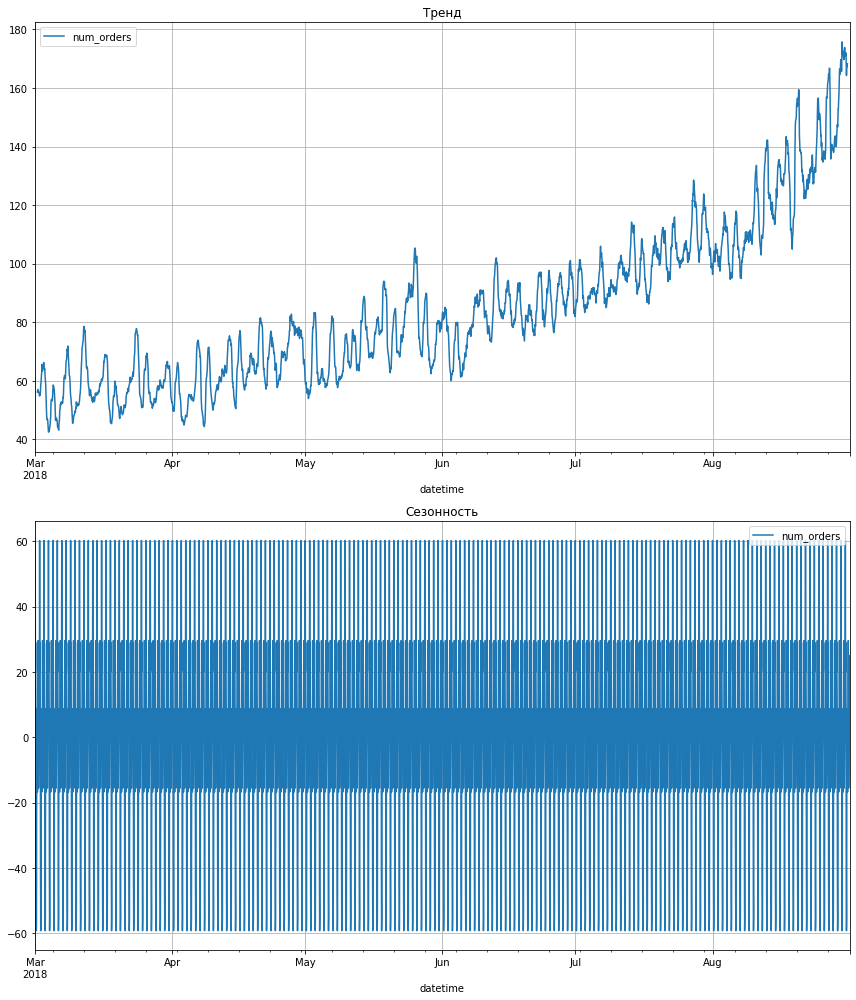

In [9]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(12, 14))
plt.subplot(211)
decomposed.trend.plot(ax=plt.gca(), grid=True)
plt.title('Тренд')
plt.subplot(212)
decomposed.seasonal.plot(ax=plt.gca(), grid=True)
plt.title('Сезонность')
plt.tight_layout()

По тренду виден рост количества заказов - «Чётенькое такси» развивается. С сезонностью не всё понятно. Посмотрим сезонность на интервале в 1 день.

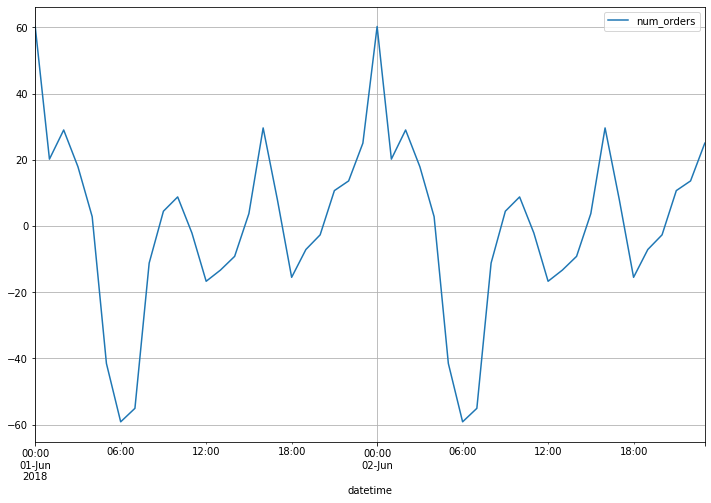

In [10]:
decomposed.seasonal['2018-06-01':'2018-06-02'].plot(ax=plt.gca(), figsize=(12, 8), grid=True)

Из исследования видно что компания «Чётенькое такси» имеет растущий тренд количества заказов из аэропортов. Так же видно что пик заказов приходится на полночь, а спад на раннее утро.

## Часть 2. Обучение моделей. 

Для предсказания возбмём 3 модели: "линейная регрессия", "случайный лес" и "градиентный бустинг" 

#### Классы и функции для решения задачи:

In [11]:
class ab_ProgressBar():
    
    def __init__(self, max=0):
        self.max_count = max
        self.spinner_state = 0
        self.progress = 0
        self.start_time = time.perf_counter()
        self.progress_step = 100 / self.max_count
        self.draw()
    
    def get_diff_time(self, t):
        return int(t // 3600), int((t // 60) % 60), int(t % 60)
    
    def get_time_string(self):
        return '{0[0]:02}:{0[1]:02}:{0[2]:02}'.format(self.get_diff_time(time.perf_counter() - self.start_time))
    
    def get_left_time_string(self):
        cur_time = time.perf_counter() - self.start_time
        try:
            return '{0[0]:02}:{0[1]:02}:{0[2]:02}'.format(self.get_diff_time(max(0, cur_time * (100 - self.progress) / self.progress)))
        except:
            return ' - '
            
    def get_fill_progress(self):
        count = int(self.progress / 2)
        return '.' * count + ' ' * int(50 - count)
    
    def draw(self):
        print(f'[{self.progress:.1f}%][time: {self.get_time_string()}][{self.get_fill_progress()}][time left: {self.get_left_time_string()}]', end='\r')
 
    def increment(self, count=1):
        self.draw()
        self.progress += self.progress_step * count
    
    def stop(self):
        print()

Функция для создания признаков.

In [12]:
class MakeFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, max_lag=1, rolling_mean_size=5, target_column='num_orders'):
        self.max_lag = max_lag
        self.rolling_mean_size = rolling_mean_size
        self.target_column = target_column
        
    def fit(self, X, y):
        self.train_tail = X.tail(max(self.max_lag, self.rolling_mean_size))
        y.drop(y.index[:max(self.max_lag, self.rolling_mean_size)], inplace=True)
        return self
    
    def transform(self, X):
        result = X.copy()
        if result.index[0] - self.train_tail.index[-1] == datetime.timedelta(days=0, hours=1):
            result = pd.concat([self.train_tail, result])
        result['day'] = result.index.day
        result['dayofweek'] = result.index.dayofweek
        for lag in range(1, self.max_lag + 1):
            result[f'lag_{lag}'] = result[self.target_column].shift(lag)
       
        result['rolling_mean'] = result['lag_1'].rolling(self.rolling_mean_size).mean()
        result = result.dropna()
        result = result.drop([self.target_column], axis=1)
        return result

Функция для выделения целевого признака и разобивки выборки на тестовую,  и тренировочную

In [13]:
class DataSplitter():
    
    def __init__(self, random_state=RANDOM_STATE):
        self.random_state = random_state
    
    def split_target(self, df, target_column, need_drop_target):
        result = {'X': df, 'y': df[target_column]}
        if need_drop_target:
            result['X'] = result['X'].drop([target_column])
        return result
    
    def split(self, df, target_column='num_orders', 
              part=None, test_size=0.1, valid_size=0.25, 
              shuffle=False, need_drop_target=False, train_with_valid=False):
        train_test = train_test_split(df, test_size=test_size, 
                                      shuffle=shuffle, random_state=self.random_state)
        train_valid = train_test_split(train_test[0], test_size=valid_size, 
                                       shuffle=shuffle, random_state=self.random_state)
        split_data = {}
        if train_with_valid:
            split_data['train'] = self.split_target(train_test[0], target_column, need_drop_target)
        else:
            split_data['train'] = self.split_target(train_valid[0], target_column, need_drop_target)
        split_data['test'] = self.split_target(train_test[1], target_column, need_drop_target)
        split_data['valid'] = self.split_target(train_valid[1], target_column, need_drop_target)
        try:
            self.X = split_data[part]['X']
            self.y = split_data[part]['y']
        except:
            self.X = {'train': split_data['train']['X'], 'test': split_data['test']['X'], 'valid': split_data['valid']['X']}
            self.y = {'train': split_data['train']['y'], 'test': split_data['test']['y'], 'valid': split_data['valid']['y']}

Переменная для параметров моделей

In [14]:
models = pd.DataFrame()

<a id='10.4-bullet'></a> 
### 4. Обучение модели "Линейная регрессия". 

In [15]:
def best_score_LinearRegression(df, params):
    progress_bar = ab_ProgressBar(len(params['max_lag']) * len(params['rolling_mean_size']) - 1)
    
    result = {}
    split_data = DataSplitter()
    split_data.split(df)
    for max_lag in params['max_lag']:
        for rolling_mean_size in params['rolling_mean_size']:
            y_train = split_data.y['train'].copy()
            pipe = Pipeline([('featuremakers', MakeFeatures(rolling_mean_size=rolling_mean_size, max_lag=max_lag)),
                             ('normalizer', StandardScaler()),
                             ('classifier', LinearRegression())])
            pipe.fit(split_data.X['train'], y_train)
            RMSE = mean_squared_error(split_data.y['valid'], pipe.predict(split_data.X['valid'])) ** 0.5
            if ('RMSE' not in result.keys()) or (RMSE < result['RMSE']):
                result = {
                    'Model': 'LinearRegression', 
                    'max_lag': max_lag,
                    'rolling_mean_size': rolling_mean_size,
                    'RMSE': RMSE
                }
            progress_bar.increment()
    progress_bar.stop()
    return result

In [16]:
if LOW_SEARCH_DEPTH:
    params = {
        'max_lag': range(39, 60, 10),
        'rolling_mean_size': range(31, 102, 10)
    }
else:
    params = {
        'max_lag': range(1, 50, 4),
        'rolling_mean_size': range(1, 102, 10)
    }
models = models.append(best_score_LinearRegression(data, params), ignore_index=True)
print('Лучшая модель линейной регрессии:')
display(models.tail(1))

[100.0%][time: 00:00:11][................................................. ][time left: 00:00:00]
Лучшая модель линейной регрессии:


,Model,RMSE,max_lag,rolling_mean_size
0,LinearRegression,29.527543,49.0,101.0


<a id='10.5-bullet'></a> 
### 5. Обучение модели "Случайный лес". 

In [17]:
def best_score_RandomForest(df, params):
    progress_bar = ab_ProgressBar(len(params['max_lag']) * 
                                  len(params['rolling_mean_size']) * 
                                  sum(params['max_depth']) * 
                                  sum(params['n_estimators']) - 1)
    
    result = {}
    split_data = DataSplitter()
    split_data.split(df)
    
    for rolling_mean_size, max_depth, n_estimators, max_lag in product(
        params['rolling_mean_size'], 
        params['max_depth'], 
        params['n_estimators'],
        params['max_lag'], 
    ):
        y_train = split_data.y['train'].copy()
        pipe = Pipeline([('featuremakers', MakeFeatures(rolling_mean_size=rolling_mean_size, max_lag=max_lag)),
                         ('classifier', RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators))])
        pipe.fit(split_data.X['train'], y_train)
        RMSE = mean_squared_error(split_data.y['valid'], pipe.predict(split_data.X['valid'])) ** 0.5
        if ('RMSE' not in result.keys()) or (RMSE < result['RMSE']):
            result = {
                'Model': 'RandomForestRegressor', 
                'max_lag': max_lag,
                'rolling_mean_size': rolling_mean_size,
                'max_depth': max_depth,
                'n_estimators': n_estimators,
                'RMSE': RMSE
            }
        progress_bar.increment(max_depth * n_estimators)
    progress_bar.stop()
    return result

In [18]:
if LOW_SEARCH_DEPTH:
    params['max_depth'] = range(5, 30, 12) 
    params['n_estimators'] = range(60, 101, 20)
else:
    params['max_depth'] = range(1, 30, 4) 
    params['n_estimators'] = range(20, 101, 20)
models = models.append(best_score_RandomForest(data, params), ignore_index=True)
print('Лучшая модель случайный лес:')
display(models.tail(1))

[99.0%][time: 00:21:02][................................................. ][time left: 00:00:12]
Лучшая модель случайный лес:


,Model,RMSE,max_lag,rolling_mean_size,max_depth,n_estimators
1,RandomForestRegressor,29.933567,59.0,61.0,29.0,60.0


<a id='10.6-bullet'></a> 
### 6. Обучение модели "Градиентный бустинг". 

In [19]:
def best_score_LGBMRegressor(df, params):
    progress_bar = ab_ProgressBar(len(params['max_lag']) * 
                                  len(params['rolling_mean_size']) * 
                                  sum(params['max_depth']) * 
                                  sum(params['n_estimators']) *
                                  len(params['boosting_type']))
    
    result = {}
    split_data = DataSplitter()
    split_data.split(df)
    
    for rolling_mean_size, max_depth, n_estimators, boosting_type, max_lag in product(
        params['rolling_mean_size'], 
        params['max_depth'], 
        params['n_estimators'],
        params['boosting_type'],
        params['max_lag']
    ):
        y_train = split_data.y['train'].copy()
        pipe = Pipeline([('featuremakers', MakeFeatures(rolling_mean_size=rolling_mean_size, max_lag=max_lag)),
                         ('classifier', LGBMRegressor(max_depth=max_depth, n_estimators=n_estimators, boosting_type=boosting_type))])
        pipe.fit(split_data.X['train'], y_train)
        RMSE = mean_squared_error(split_data.y['valid'], pipe.predict(split_data.X['valid'])) ** 0.5
        if ('RMSE' not in result.keys()) or (RMSE < result['RMSE']):
            result = {
                'Model': 'LGBMRegressor', 
                'max_lag': max_lag,
                'rolling_mean_size': rolling_mean_size,
                'max_depth': max_depth,
                'n_estimators': n_estimators,
                'boosting_type': boosting_type,
                'RMSE': RMSE
            }
        progress_bar.increment(max_depth * n_estimators)
    progress_bar.stop()
    return result

In [20]:
params['boosting_type'] = ('gbdt', 'dart', 'goss')
models = models.append(best_score_LGBMRegressor(data, params), ignore_index=True)
print('Лучшая модель градиентный бустинг:')
display(models.tail(1))

[99.7%][time: 00:20:28][................................................. ][time left: 00:00:04]
Лучшая модель градиентный бустинг:


,Model,RMSE,max_lag,rolling_mean_size,max_depth,n_estimators,boosting_type
2,LGBMRegressor,29.324834,49.0,91.0,17.0,100.0,gbdt


Вот весь список получившихся молучших моделей, отсортированных по убыванию качества предсказания.

In [21]:
display(models.sort_values('RMSE'))

,Model,RMSE,max_lag,rolling_mean_size,max_depth,n_estimators,boosting_type
2,LGBMRegressor,29.324834,49.0,91.0,17.0,100.0,gbdt
0,LinearRegression,29.527543,49.0,101.0,NaN,NaN,NaN
1,RandomForestRegressor,29.933567,59.0,61.0,29.0,60.0,NaN


## Часть 2. Анализ моделей. 

Проверим наилучшие модели на тестовой выборке.

Разделим сразу данные

In [22]:
train = DataSplitter()
train.split(data, part='train', train_with_valid=True)
test = DataSplitter()
test.split(data, part='test')

<a id='10.7-bullet'></a> 
### 7. Проверка модели "Линейная регрессия" на тестовой выборке. 

In [23]:
y_train = train.y.copy()
rolling_mean_size = models[models.Model == 'LinearRegression'].iloc[0]['rolling_mean_size']
max_lag = models[models.Model == 'LinearRegression'].iloc[0]['max_lag']
pipe = Pipeline([('featuremakers', MakeFeatures(rolling_mean_size=int(rolling_mean_size), max_lag=int(max_lag))),
                 ('normalizer', StandardScaler()),
                 ('classifier', LinearRegression())])
pipe.fit(train.X, y_train)
RMSE = mean_squared_error(test.y, pipe.predict(test.X)) ** 0.5
print('RMSE лучшей модели "Линейная регрессия"', RMSE)

RMSE лучшей модели "Линейная регрессия" 41.77474175414792


<a id='10.8-bullet'></a> 
### 8. Проверка модели "Случайный лес" на тестовой выборке. 

In [24]:
y_train = train.y.copy()
rolling_mean_size = models[models.Model == 'RandomForestRegressor'].iloc[0]['rolling_mean_size']
max_lag = models[models.Model == 'RandomForestRegressor'].iloc[0]['max_lag']
max_depth = models[models.Model == 'RandomForestRegressor'].iloc[0]['max_depth']
n_estimators = models[models.Model == 'RandomForestRegressor'].iloc[0]['n_estimators']
pipe = Pipeline([('featuremakers', MakeFeatures(rolling_mean_size=int(rolling_mean_size), max_lag=int(max_lag))),
                 ('classifier', RandomForestRegressor(max_depth=int(max_depth), n_estimators=int(n_estimators)))])
pipe.fit(train.X, y_train)
RMSE = mean_squared_error(test.y, pipe.predict(test.X)) ** 0.5
print('RMSE лучшей модели "Случайный лес"', RMSE)

RMSE лучшей модели "Случайный лес" 42.31689522719242


<a id='10.9-bullet'></a> 
### 9. Проверка модели "Градиентный бустинг" на тестовой выборке. 

In [25]:
y_train = train.y.copy()
rolling_mean_size = models[models.Model == 'LGBMRegressor'].iloc[0]['rolling_mean_size']
max_lag = models[models.Model == 'LGBMRegressor'].iloc[0]['max_lag']
max_depth = models[models.Model == 'LGBMRegressor'].iloc[0]['max_depth']
n_estimators = models[models.Model == 'LGBMRegressor'].iloc[0]['n_estimators']
boosting_type = models[models.Model == 'LGBMRegressor'].iloc[0]['boosting_type']
pipe = Pipeline([('featuremakers', MakeFeatures(rolling_mean_size=int(rolling_mean_size), max_lag=int(max_lag))),
                 ('classifier', LGBMRegressor(max_depth=int(max_depth), n_estimators=int(n_estimators), boosting_type=boosting_type))])
pipe.fit(train.X, y_train)
RMSE = mean_squared_error(test.y, pipe.predict(test.X)) ** 0.5
print('RMSE лучшей модели "Градиентный бустинг"', RMSE)

RMSE лучшей модели "Градиентный бустинг" 40.40346495555961


<a id='10.10-bullet'></a> 
### 10. Вывод. 

Модель "Градиентный бустинг" дала наилучший результат предсказания на тестовой выборке **RMSE = 40.4**, по этому для предсказания стоит выбрать именно эту модель со следующими гиперпараметрами:
- max_depth = 17
- n_estimators = 100
- boosting_type = 'gbdt'

Кроме того, необходимо подготовить следующие признаки для каждого объекта:
- num_orders за предыдущие 49 дней
- скользящая средняя для предыдущего дня с временным интервалом в 91 час

Судя по тому что значения *n_estimators* и *max_lag* наилучшей модели находятся на границе исследуемого диапазона, то увеличение этих значений может дать ещё большее качество модели, но полученное значение метрики RMSE = 40.4 уже удовлетворяет условию что "начение метрики RMSE на тестовой выборке должно быть не больше 48", а при больших значениях данных параметров скорость обучения и предсказания модели может просесть.

Выведем график фактического и предсказанного значений на тестовой выборке для лучшей модели "градиентный бустинг" (уже в *pipe*)

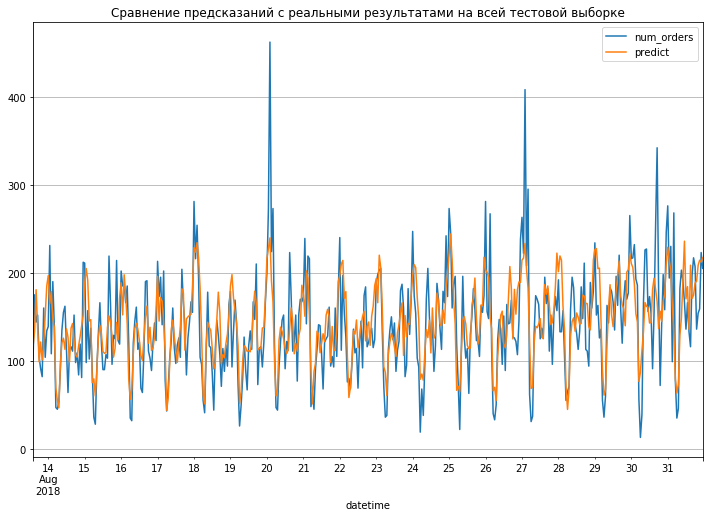

In [28]:
comparison_data = pd.DataFrame(test.y)
comparison_data['predict'] = pipe.predict(test.X)
comparison_data.plot(grid=True, figsize=(12, 8), 
                     title='Сравнение предсказаний с реальными результатами на всей тестовой выборке')

Рассмотрим в маштабе 2 дней:

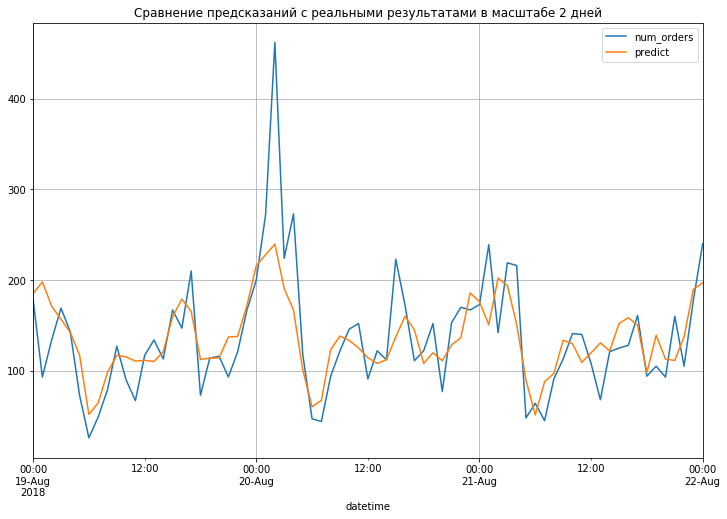

In [30]:
comparison_data['2018-08-19 00:00:00':'2018-08-22 00:00:00'].plot(
    grid=True, figsize=(12, 8),
    title='Сравнение предсказаний с реальными результатами в масштабе 2 дней')

По графику видно, что в целом предсказанный рисунок повторяет реальный результат, но явно не может предвидеть величину всплесков. Таким образом сам факт увеличения или уменьшения объёмов заказов предсказывается верно, но масштаб зачастую недооценивается. В целом такой результат можно считать удовлетворительным, так как внутрисуточная цикличность предсказана верно, тот факт что масштаб серьёзно недооценивается в некоторых случаях скорее является случайным труднопрогнозируемым по голым цифрам событием, как на втором графике. Исключением становится крайняя левая часть первого графика, где сезонность серьёзно сбивается, что приводит к рассинхронизации предсказаний и реальных значений.

Если же рассмотреть внешние факторы, то август это месяц бурного возвращения из отпусков и, очевидно, всплески заказов такси в аэропорты в выходные дни серьёзно увеличиваются, что не возможно предсказать по нескольким предыдущим месяцам, тут надо знать статистику на несколько лет, чтобы модель учла этот факт. Конец августа, начало сентября так же специфичное время - конец лета.

Таким образом, чтобы обучить более качественную модель, нужно иметь больше данных (несколько лет), тогда сезонные колебания не будут для неё неожиданностью.

С другой стороны, введи в модель данные по авиарейсам из аэропортов, которые расписаны на несколько дней вперёд, и модель в разы повысит своё качество.